In [9]:

##------------------Fig 2----------------

import matplotlib.pyplot as plt
from openpyxl import load_workbook
# import xlrd
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
%matplotlib inline
import math
from scipy.interpolate import make_interp_spline
from scipy.signal import savgol_filter


table = pd.read_excel('./case-comparison.xlsx',sheet_name="Sheet1")
# print("table",table)

for index, row in table.iterrows():    
    test=0
    test2=0
    test =row[4]+ (np.random.rand()+0.1)/10
    test2 =row[7]+ (np.random.rand()+0.2)/10    
    table.loc[index,11] = round(test,2)
    table.loc[index,12] = round(test2,2)
x_data = table.iloc [50:280, 0]
y1 = table.iloc[50:280,11]
y = table.iloc[50:280,12]

y_initial = savgol_filter(y1, 30, 8, mode= 'nearest')
y_reproduced = savgol_filter(y, 20, 9, mode= 'nearest')

plt.figure(figsize=(5,2),dpi=200)
# plt.gcf().subplots_adjust(left=0,top=0.1,bottom=0, right=0.1)
plt.gcf().subplots_adjust(top=0.8,bottom=0.3,)
plt.rcParams['font.size'] = 8
plt.rcParams['font.family']='Times New Roman'
plt.plot(x_data,y_initial, color='crimson',linewidth=0.7, label='Reproduced outputs',linestyle='-')
plt.plot(x_data,y_reproduced,color='dodgerblue',linewidth=0.7, label='Original outputs',linestyle='-')

plt.xticks(rotation=0)
plt.fill_between(x_data, y_initial, y_reproduced, facecolor='grey', alpha=0.3)
plt.legend(["Initial outputs", "Reproduced outputs", "Differences"],loc="upper left", ncol=1, prop={"family": "Times New Roman", "size": 6})

plt.rcParams['axes.facecolor'] = 'white'
plt.grid(False)  # 添加网格，true 首字母大写
plt.axis(True)
ax=plt.gca()
ax.spines['bottom'].set_color('black') 
ax.spines['left'].set_color('black') 
ax.spines['right'].set_color('black') 
ax.spines['top'].set_color('black') 
# ax.axes.labelsize
ax.xaxis.label.set_color('black') 
ax.tick_params(axis='x', colors='black')
ax.set_xlabel('Time')
ax.set_ylabel('Runoff (m^3/s) of ens0')
    
plt.savefig('test.svg')


FileNotFoundError: [Errno 2] No such file or directory: './case-comparison.xlsx'

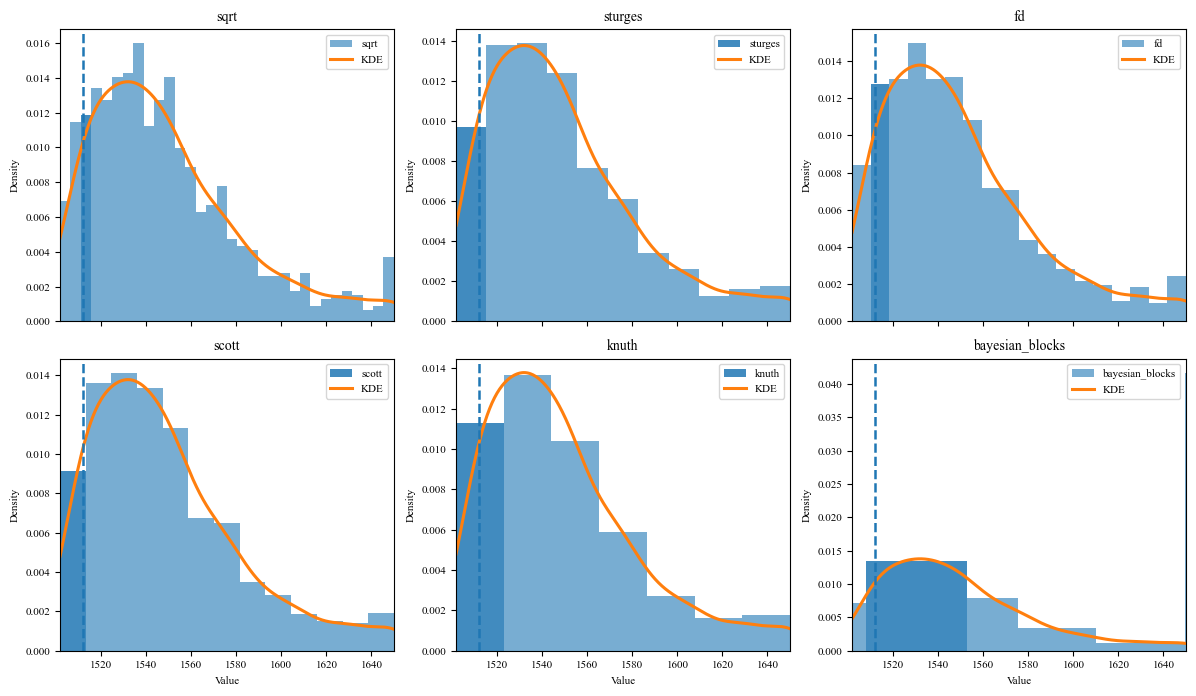

In [75]:
##------------------Fig 6----------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from astropy.stats import knuth_bin_width, bayesian_blocks

# -----------------------------
# 1) Same data for all methods
# -----------------------------
rng = np.random.default_rng(42)
N = 1000
a, b = 1500, 1650

y = a + rng.gamma(shape=2.0, scale=25.0, size=N)
y = np.clip(y, a, b)

y0 = 1512.0  # original value (vertical dashed line)

# -----------------------------
# 2) Bin-edge calculators
# -----------------------------
def edges_sqrt(data):
    k = int(np.ceil(np.sqrt(len(data))))
    return np.histogram_bin_edges(data, bins=k)

def edges_sturges(data):
    k = int(np.ceil(np.log2(len(data)) + 1))
    return np.histogram_bin_edges(data, bins=k)

def edges_fd(data):
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    n = len(data)
    if iqr == 0:
        return np.histogram_bin_edges(data, bins="auto")
    h = 2 * iqr * (n ** (-1/3))
    k = int(np.ceil((data.max() - data.min()) / h)) if h > 0 else 1
    return np.histogram_bin_edges(data, bins=max(k, 1))

def edges_scott(data):
    n = len(data)
    sigma = np.std(data, ddof=1)
    if sigma == 0:
        return np.histogram_bin_edges(data, bins="auto")
    h = 3.5 * sigma * (n ** (-1/3))
    k = int(np.ceil((data.max() - data.min()) / h)) if h > 0 else 1
    return np.histogram_bin_edges(data, bins=max(k, 1))

def edges_knuth(data):
    width = knuth_bin_width(data, return_bins=False)
    if not np.isfinite(width) or width <= 0:
        return np.histogram_bin_edges(data, bins="auto")
    k = int(np.ceil((data.max() - data.min()) / width))
    return np.histogram_bin_edges(data, bins=max(k, 1))

def edges_bayesian_blocks(data):
    return bayesian_blocks(data, fitness="events", p0=0.05)

methods = [
    ("sqrt", edges_sqrt),
    ("sturges", edges_sturges),
    ("fd", edges_fd),
    ("scott", edges_scott),
    ("knuth", edges_knuth),
    ("bayesian_blocks", edges_bayesian_blocks),
]

# -----------------------------
# 3) Plot helper
# -----------------------------
def plot_hist_kde(ax, data, edges, title, y0=None):
    hist_vals, bin_edges, patches = ax.hist(
        data, bins=edges, density=True, alpha=0.60, label=title
    )

    xs = np.linspace(np.min(data), np.max(data), 400)
    kde = gaussian_kde(data)
    ax.plot(xs, kde(xs), linewidth=2.2, label="KDE")

    if y0 is not None:
        ax.axvline(y0, linestyle="--", linewidth=1.8)
        idx = np.searchsorted(bin_edges, y0, side="right") - 1
        if 0 <= idx < len(patches):
            patches[idx].set_alpha(0.85)

    ax.set_title(title, fontsize=10)
    ax.set_ylabel("Density")
    ax.legend(fontsize=8, frameon=True)

# -----------------------------
# 4) 2x3 comparison figure (shared x-axis)
# -----------------------------
fig, axes = plt.subplots(2, 3, figsize=(12, 7), sharex=True)
axes = axes.ravel()

# Fix x-limits so all panels align perfectly
xmin, xmax = y.min(), y.max()

for ax, (name, edge_fn) in zip(axes, methods):
    edges = edge_fn(y)
    plot_hist_kde(ax, y, edges, title=name, y0=y0)
    ax.set_xlim(xmin, xmax)

# Only bottom row shows x-axis tick labels + x label
for i, ax in enumerate(axes):
    if i < 3:  # top row
        ax.tick_params(labelbottom=False)  # hide x tick labels
        ax.set_xlabel("")
    else:      # bottom row
        ax.set_xlabel("Value")

# fig.suptitle("Frequency Distribution and KDE (Same Data, Different Binning Rules)", fontsize=12)
plt.tight_layout()
plt.show()

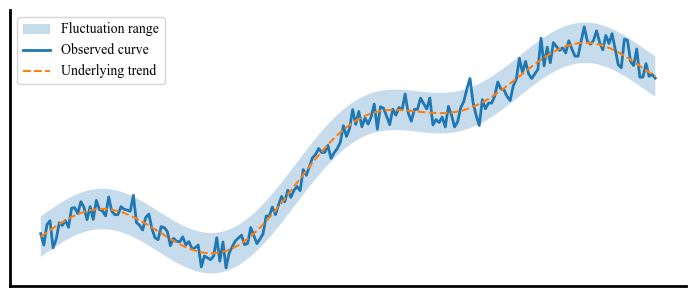

In [76]:
##------------------Fig 7----------------

import numpy as np
import matplotlib.pyplot as plt

# --- Data (example) ---
rng = np.random.default_rng(42)
x = np.linspace(0, 10, 200)

trend = 0.25 + 0.25 * np.tanh((x - 5) / 1.6) + 0.08 * np.sin(1.6 * x)
# trend =  0.1 * np.tanh((x - 5) / 1.8) + 0.01 * np.sin(1.6 * x)

y = trend + rng.normal(0, 0.03, size=x.size)

sigma = 0.03
lower = trend - 2 * sigma
upper = trend + 2 * sigma

threshold = 0.65

# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 3))

ax.fill_between(x, lower, upper, alpha=0.25, label="Fluctuation range")
ax.plot(x, y, linewidth=2, label="Observed curve")
ax.plot(x, trend, linestyle="--", label="Underlying trend")
# ax.axhline(threshold, linestyle=":", label="Threshold")

# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_title("Curve with Threshold and Fluctuation Range")
ax.legend(fontsize=10)

# Hide axis numbers (no tick labels)
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

# Keep only left & bottom spines (axes lines)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Thicken left & bottom spines
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)

# Transparent background
fig.patch.set_alpha(0)
ax.set_facecolor("none")
plt.tight_layout()
plt.show()

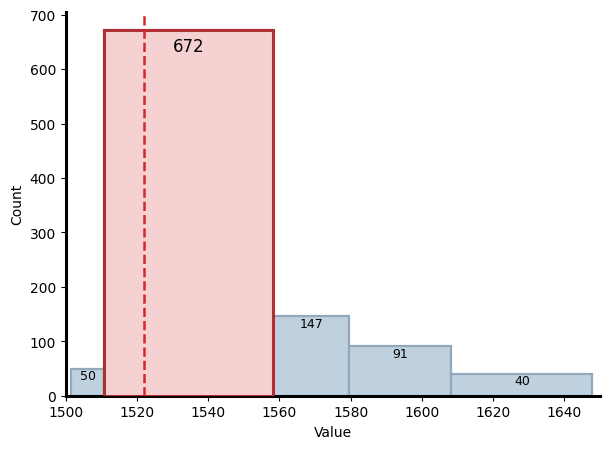

In [2]:
##------------------Fig 8----------------

import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import bayesian_blocks
from matplotlib.patches import Rectangle

rng = np.random.default_rng(2026)
N = 1000
a, b = 1500, 1650

# --- Truncated sampling instead of clip (avoid boundary pile-up) ---
y = []
while len(y) < N:
    cand = a + rng.gamma(shape=2.2, scale=22.0, size=N)
    cand = cand[(cand >= a) & (cand <= b)]
    y.extend(cand.tolist())
y = np.array(y[:N])

y0 = 1522.0

# Bayesian Blocks edges
edges = bayesian_blocks(y, fitness="events", p0=0.05)

# --- Colors ---
bar_fill = "#BFD0DE"
bar_edge = "#93A9BB"

highlight_fill = "#FAD2D2"
highlight_edge = "#AD282A"

fig, ax = plt.subplots(figsize=(6.2, 4.6))

# ---- COUNT histogram (density=False) ----
hist_vals, bin_edges, patches = ax.hist(
    y,
    bins=edges,
    density=False,          # <-- Count
    alpha=1.0,
    color=bar_fill,
    edgecolor=bar_edge,
    linewidth=1.6,
    label="Bayesian blocks"
)

# Annotate count on each bin (integer)
for i, h in enumerate(hist_vals):
    if h <= 0:
        continue
    x_center = 0.5 * (bin_edges[i] + bin_edges[i + 1])
    ax.text(x_center, h * 0.98, f"{int(h)}", ha="center", va="top", fontsize=9)

# ---- highlight the bin containing y0 with a full-width rectangle ----
idx = np.searchsorted(bin_edges, y0, side="right") - 1
if 0 <= idx < len(hist_vals):
    x_left  = bin_edges[idx]
    x_right = bin_edges[idx + 1]
    width = x_right - x_left
    height = hist_vals[idx]  # <-- Count height

    rect = Rectangle(
        (x_left, 0), width, height,
        facecolor=highlight_fill,
        edgecolor=highlight_edge,
        linewidth=2.2,
        alpha=0.95,
        zorder=5
    )
    ax.add_patch(rect)
        # re-draw the count label on top of the highlighted (pink) bin
    ax.text(
        (x_left + x_right) / 2,
        height * 0.98,
        f"{int(height)}",
        ha="center",
        va="top",
        fontsize=12,
        zorder=7
    )

# y0 vertical line (red)
ax.axvline(y0, linestyle="--", linewidth=1.8, color="#d62728", label="y0", zorder=6)

ax.set_xlim(a, b)
ax.set_xlabel("Value")
ax.set_ylabel("Count")

# Only keep left & bottom spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(2.2)
ax.spines["bottom"].set_linewidth(2.2)
# ax.text(x_center, h * 0.98, f"{int(h)}", ha="center", va="top", fontsize=9, zorder=7)
# ax.legend(fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

/Users/mimi/miniconda3/envs/pip39/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


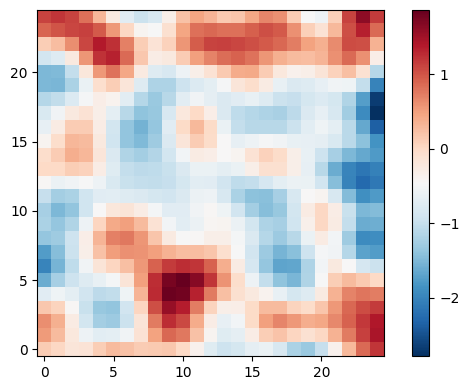

In [7]:

##------------------Fig 12 +Fig 13(d)----------------


import numpy as np
import pandas as pd
import gstools as gs
from sklearn.preprocessing import KBinsDiscretizer
from hmmlearn import hmm
import matplotlib.pyplot as plt

# 定义数据维度
dimensionxy = 25

# 生成数据
x = np.linspace(0, 25, 25)
y = np.linspace(0, 25, 25)
XX, YY = np.meshgrid(x, y)

# 第一个数据
model = gs.Gaussian(dim=2, var=1, len_scale=3)
srf = gs.SRF(model, mean=0.)
srf((x, y), mesh_type='structured')
B0 = srf((x, y), mesh_type='structured', seed=100)

# 定义状态数
n_states = 5
est = KBinsDiscretizer(n_bins=n_states, encode='ordinal', strategy='uniform')
B_discretized = est.fit_transform(B0).astype(int)


# # 可视化
fig, axes = plt.subplots(1, 1, figsize=(6, 4))

# 原始随机场带噪声
im0 = axes.imshow(B0, origin='lower', cmap='RdBu_r')
# axes.set_title('Initial with Noise')
fig.colorbar(im0, ax=axes)


plt.tight_layout()
plt.show()


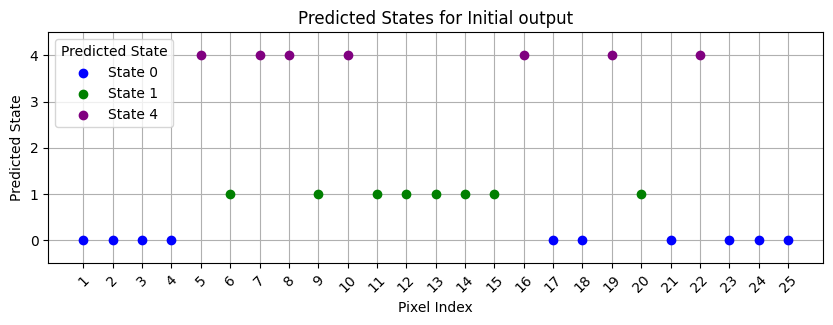

In [1]:
##------------------Fig 12 +Fig 13(a)----------------

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from itertools import combinations
import warnings 
warnings.filterwarnings("ignore")



out0 =pd.read_csv("./initial-out/pred_nonoisy_initial.csv")

# 将数据展开为一维数组
data_values = out0.values.flatten()

# 创建颜色映射
colors = {0: 'blue', 1: 'green', 2: 'orange', 3: 'red', 4: 'purple'}

# 创建图形
plt.figure(figsize=(10, 3))

# 为每个分类状态绘制不同颜色的点
for value in np.unique(data_values):
    indices = np.where(data_values == value)
    plt.scatter(indices, data_values[indices], color=colors[value], label=f'State {value}',zorder=3)

# 绘制网格线在散点图之下
plt.grid(True, zorder=0)

# 确保散点图在网格线之上
plt.xlabel('Pixel Index')
plt.ylabel('Predicted State')
plt.title('Predicted States for Initial output')
plt.xticks(range(len(data_values)), labels=[f'{i+1}' for i in range(len(data_values))], rotation=45)
plt.yticks(np.arange(0, 5, 1))  # 设置 y 轴刻度为 0 到 4
plt.ylim(-0.5, 4.5)  # 限制 y 轴范围从 -0.1 到 4.01
plt.legend(title='Predicted State')  # 添加图例

plt.show()



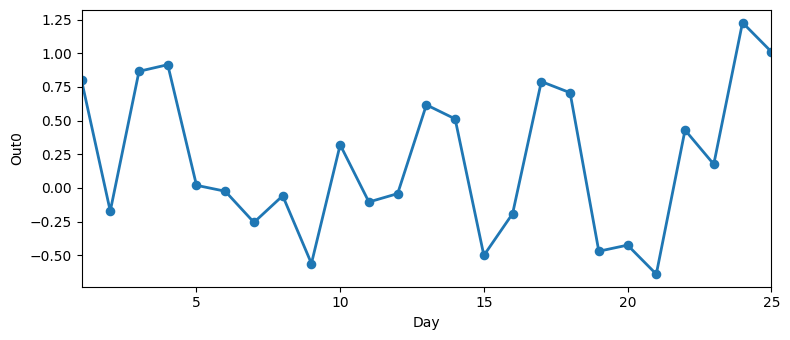

In [10]:
##------------------Fig 13(b)----------------


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# df = pd.read_csv("./repro-out/pred_nonoisy.csv")
out0 = pd.read_csv("./initial-out13b/pred_nonoisy_initial.csv")

# 选要画的列：Out0（标签）或 value0（数值）
y = out0["Out0"].to_numpy()     # 或：out0["value0"].to_numpy()
x = np.arange(1, len(y) + 1)

plt.figure(figsize=(8, 3.5))
plt.plot(x, y, linewidth=2.0)          # 折线
plt.scatter(x, y, s=35)                # 点（可选，方便看离散跳变）

plt.xlim(1, len(y))
plt.xlabel("Day")
plt.ylabel("Out0")
plt.tight_layout()
plt.show()

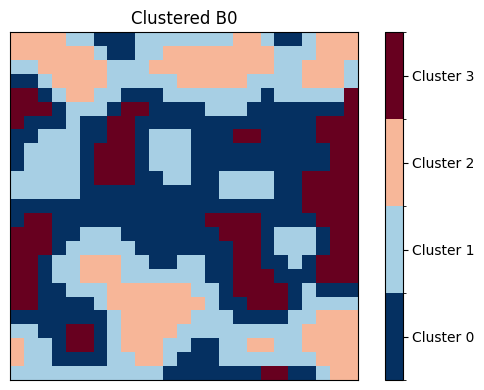

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [11]:
##------------------Fig 13(c)----------------


import numpy as np
import gstools as gs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns

x = np.linspace(0, 25, 25)
y = np.linspace(0, 25, 25)
XX, YY = np.meshgrid(x, y)
#第一个数据

model = gs.Gaussian(dim=2, var=1,len_scale=3)
srf = gs.SRF(model,mean=0.)
srf((x, y), mesh_type='structured')
B0=srf((x, y), mesh_type='structured',seed=100)



# 将B0转换为适合聚类的格式
data = B0.reshape(-1, 1)

def process_data_with_randomness_SINGLE(data):
    kmeans = KMeans(n_clusters=4, n_init=10).fit(data)
    labels = kmeans.labels_
    clustered_B0 = labels.reshape(B0.shape)

    fig, ax = plt.subplots(figsize=(6, 4))

    # Use the same colormap name, but discretize into 4 classes
    cmap = plt.get_cmap("RdBu_r", 4)  # 4 discrete colors from RdBu_r
    bounds = [0, 1, 2, 3, 4]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    im1 = ax.imshow(clustered_B0, cmap=cmap, norm=norm, origin="lower")
    ax.set_title("Clustered B0")
    ax.set_xticks([])
    ax.set_yticks([])

    cbar = fig.colorbar(im1, ax=ax, ticks=[0.5, 1.5, 2.5, 3.5])
    cbar.ax.set_yticklabels(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"])

    plt.tight_layout()
    plt.show()

    return labels

def process_data_with_randomness(data):
# 进行K-means聚类分析
    kmeans = KMeans(n_clusters=4,n_init=10).fit(data)
    labels = kmeans.labels_
    return labels


def calcuCirculation_for_point(data,time):
    all_processed_values = []
    results_df = pd.DataFrame()
    if time == 2:
        for i in range(1, time):
            processed_values = process_data_with_randomness_SINGLE(data)
            all_processed_values.append(pd.Series(processed_values, name=f'Out0'))
        results_df = pd.concat(all_processed_values, axis=1)
        rowpro=results_df.iloc[11]
        # 将提取出的第 11 行转换为 DataFrame，以便于保存为 CSV 文件
        row_11_df = rowpro.to_frame().T
        # row_11_df.to_csv('nitial-out/pred_nonoisy_initial.csv')
        # results_df["value"] =B0.ravel()
        row_11_df.to_csv("initial-out/pred_nonoisy_initial.csv", index=False)
    if time != 2:
        for i in range(1, time):
            print(i)
            processed_values = process_data_with_randomness(data)
            all_processed_values.append(pd.Series(processed_values, name=f'Out{i}'))
        # results_df = pd.concat(all_processed_values, axis=1)
        # results_df["value"] =B0.ravel()
        # rowpro=results_df.iloc[11]
        # row_11_df = rowpro.to_frame().T
        # row_11_df.to_csv("repro-out/pred_nonoisy.csv", index=False)
        # 检查结果
        # print(results_df)

times = 1001
calcuCirculation_for_point(data, 2)
calcuCirculation_for_point(data, times)


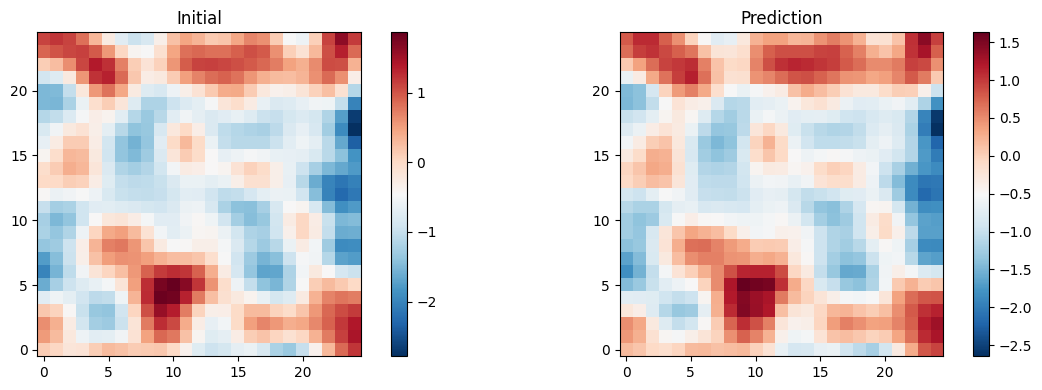

In [8]:
##------------------Fig 13(d)----------------

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('path to local MGWR repository copy')

import gstools as gs


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import seaborn as sns


x = np.linspace(0, 25, 25)
y = np.linspace(0, 25, 25)
XX, YY = np.meshgrid(x, y)
#第一个数据

model = gs.Gaussian(dim=2, var=1,len_scale=3)
srf = gs.SRF(model,mean=0.)
srf((x, y), mesh_type='structured')
B0=srf((x, y), mesh_type='structured',seed=100)


#运行1000次
# 将数据转换为适合随机森林模型的格式
X = np.column_stack([XX.ravel(), YY.ravel()])
y = B0.ravel()

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练随机森林模型
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
def process_data_with_randomness(X_train, X_test, y_train, y_test):
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train, y_train)

    # 进行预测
    y_pred = rf.predict(X_test)

    # 计算均方误差
    mse = mean_squared_error(y_test, y_pred)
    # print(f'随机森林模型的均方误差: {mse}')

    # 生成预测结果
    y_pred_full = rf.predict(X).reshape(XX.shape)
    # 可视化
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 原始随机场带噪声
    im0 = axes[0].imshow(B0, origin='lower', cmap='RdBu_r')
    axes[0].set_title('Initial')
    fig.colorbar(im0, ax=axes[0])

    # 随机森林预测结果
    im1 = axes[1].imshow(y_pred_full, origin='lower', cmap='RdBu_r')
    axes[1].set_title('Prediction')
    fig.colorbar(im1, ax=axes[1])

    plt.tight_layout()
    plt.show()

    y_pred_full_column = y_pred_full.ravel()
    # df = pd.DataFrame(y_pred_full_column, columns=['Predicted Values'])
    return y_pred_full_column



def calcuCirculation_for_point(X_train, X_test, y_train, y_test, time):
    all_processed_values = []
    results_df = pd.DataFrame()
    if time == 2:
        for i in range(1, time):
            processed_value = process_data_with_randomness(X_train, X_test, y_train, y_test)
            all_processed_values.append(pd.Series(processed_value, name=f'Out0'))
        results_df = pd.concat(all_processed_values, axis=1)
        results_df.to_csv("initial-out/pred_nonoisy_initial.csv", index=False)
    if time != 2:
        for i in range(1, time):
            print(i)
            processed_value = process_data_with_randomness(X_train, X_test, y_train, y_test)
            all_processed_values.append(pd.Series(processed_value, name=f'Out{i}'))
        results_df = pd.concat(all_processed_values, axis=1)
        results_df.to_csv("repro-out/pred_nonoisy.csv", index=False)
        # 检查结果
        print(results_df)

times = 1001
calcuCirculation_for_point(X_train, X_test, y_train, y_test, 2)
# calcuCirculation_for_point(X_train, X_test, y_train, y_test, times)
